모듈화하기

Boston price 예측모델
- 데이터셋 : boston.csv
- 학습종류: 지도학습 / 회귀
- 알고리즘 : Ridge, Lasso, Elastine
- 피처: 모두.
- 타겟: medv   

In [5]:
## 1-1
import pandas as pd
# 데이터 분석 및 전처리
import numpy as np
# 숫자처리
import matplotlib.pyplot as plt
# 데이터 시각화

from sklearn.linear_model import LinearRegression
                            ## ML 알고리즘
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
                            ## 성능평가 모듈
from sklearn.model_selection import train_test_split, KFold
                            ## 데이터셋 분리 관련 모듈
                            ## 학습/검증/테스트 
                                                    ## 교차검증\
from sklearn.linear_model import Ridge, Lasso, ElasticNet                                                        

In [6]:
col = 'crim	zn	indus	chas	nox	rm	age	dis	rad	tax	ptratio	b	lstat	medv'.split()
len(col)
houseDict = {x:[] for x in col}
houseDF = pd.DataFrame(pd.read_csv('../data/housing.csv', header=None))
for i in houseDF.index:
    for j in range(14):
        houseDict[col[j]].append(houseDF.iloc[i,:][0].split()[j])
houDF = pd.DataFrame(houseDict)
houDF = houDF.astype(float)


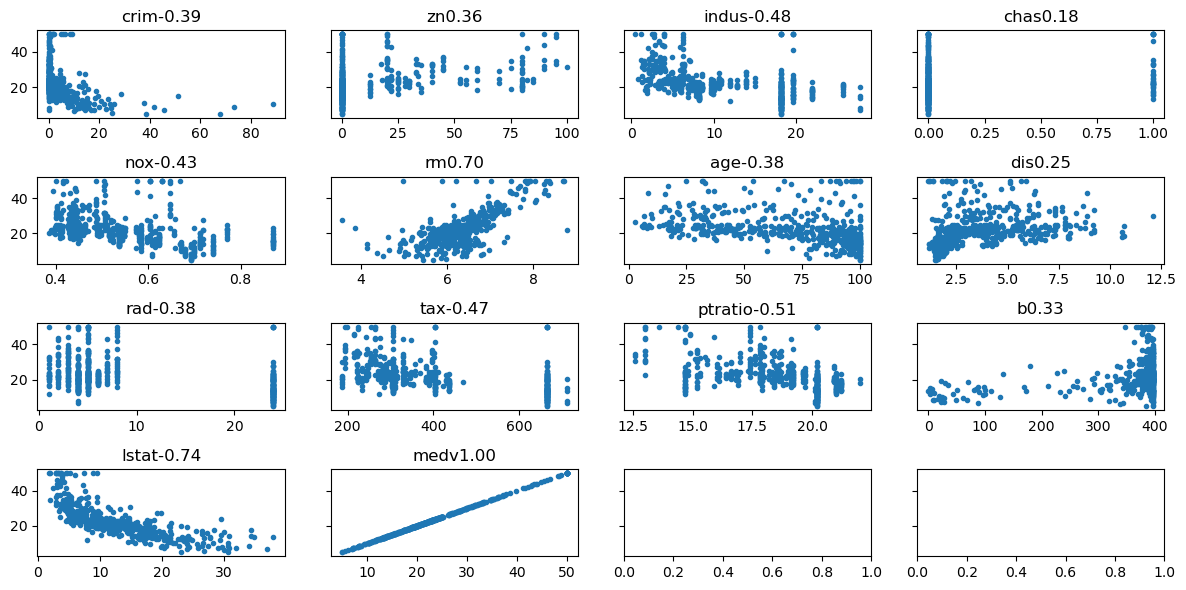

In [7]:
fig, ax = plt.subplots(4,4, sharey=True,figsize = (12,6))
ax = ax.flatten()
# print(ax[0])
for i in range(0,14):
    ax[i].plot(houDF.iloc[:,i],houDF['medv'], '.')
    ax[i].set_title(houDF.columns[i]+ str(f"{houDF.iloc[:,i].corr(houDF['medv']):.2f}"))

plt.tight_layout()
plt.show()    


In [8]:
nowDF = houDF.copy()

In [9]:
from sklearn.preprocessing import MinMaxScaler
#값의 범위가 다르므로 정규화
array = nowDF[nowDF.columns[:-1]].to_numpy()
minmax = MinMaxScaler()
narr = minmax.fit_transform(array)
nowDF[nowDF.columns[:-1]] = pd.DataFrame(narr)

In [10]:
# featureDF = nowDF[nowDF.columns[:-1]]
# targetSR = nowDF['medv']

# print(f"featureDF => {featureDF.ndim}D, targetSr => {targetSR.ndim}D")
# ## 학습용 : 테스트용 = 9:1
# X_train, X_test, y_train, y_test = train_test_split(featureDF,
#                                                     targetSR,
#                                                     random_state=5)
# print(f"X_train => {X_train.ndim}D {X_train.shape} / X_test => {X_test.ndim}D, {X_test.shape}")
# print(f"y_train => {y_train.ndim}D {y_train.shape}, / y_test => {y_test.ndim}D, {y_test.shape}")

In [11]:
# nowDF.columns[:-1]
alphaList = [0.1, 0.5, 1.0, 1.5, 2, 2.5, 3]#, 5, 10, 50, 100]
def ft_choice(columns, type, alphaList=alphaList):
    print(columns)
    featureDF = nowDF[columns]
    targetSR = nowDF['medv']

    # print(f"featureDF => {featureDF.ndim}D, targetSr => {targetSR.ndim}D")
    ## 학습용 : 테스트용 = 9:1
    X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                        targetSR,
                                                        random_state=5)
    # print(f"X_train => {X_train.ndim}D {X_train.shape} / X_test => {X_test.ndim}D, {X_test.shape}")
    # print(f"y_train => {y_train.ndim}D {y_train.shape}, / y_test => {y_test.ndim}D, {y_test.shape}")
    return RLE(type, alphaList,X_train, X_test, y_train, y_test)

In [12]:
#aglt = Ridge(alpha), Lasso(alpha), ElasticNet()
#alphaList = [0.1, 0.5, 1.0, 1.5, 2, 2.5, 3]

def RLE(type, alphaList,X_train, X_test, y_train, y_test):
    resultDF = pd.DataFrame(columns = ['alpha','train_score', 'test_score','diff', 'train_loss', 'test_loss'])
    kf = KFold()
    ## alpha값에 따른 Ridge 모델 성능 비교
    for alpha in alphaList:
        if type == 'rid':
            # print('Ridge')
            lr = Ridge(alpha)
        elif type == 'las':
            # print('Lasso')
            lr = Lasso(alpha,max_iter=5000, tol=1e-10)
        elif type == 'ela':
            # print('ElasticNet')
            lr = ElasticNet(alpha)
                        
        
        train_stotal , test_stotal = 0, 0
        train_ltotal, test_ltotal = 0, 0
        
            
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            # print(f"Fold {i}")
        # print(test_index in y_test.index)
            ## 학습용 / 테스트용 피쳐와 타겟 추출
            train_data, train_label = X_train.iloc[train_index, 1:], y_train.iloc[train_index]
            test_data, test_label = X_train.iloc[test_index, 1:], y_train.iloc[test_index]
            # print(train_data.columns)

            #학습
            lr.fit(train_data, train_label)
            
            train_score = lr.score(train_data, train_label)
            test_score = lr.score(test_data, test_label)

            train_loss = root_mean_squared_error(train_label, lr.predict(train_data))
            test_loss = root_mean_squared_error(test_label, lr.predict(test_data))

            train_stotal += train_score
            test_stotal += test_score
            train_ltotal += train_loss
            test_ltotal += test_loss
        #alpha값 별로 성능과 손실값 평균 저장하기    
        resultDF.loc[alpha] = [alpha, train_stotal/5,test_stotal/5,train_stotal/5-test_stotal/5,train_ltotal/5,test_ltotal/5]
    
    print(resultDF)
    fives(resultDF, type)

In [13]:
def fives(resultDF, title='None'):
    fig, axe = plt.subplots(1,5, figsize=(12,6), sharex=True)
    axe = axe.flatten()
    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0, 5, 24)]
    for ax, col, color1 in zip(axe, resultDF.columns[1:], colors):
        ax.plot(resultDF['alpha'], resultDF[col], color = color1, label=col)
        ax.legend()

    fig.suptitle(title)


Index(['zn', 'indus'], dtype='object')
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.238185    0.220008  0.018177    8.041477   8.075367
0.5    0.5     0.238028    0.220356  0.017672    8.042312   8.075269
1.0    1.0     0.237568    0.220487  0.017081    8.044747   8.076552
1.5    1.5     0.236857    0.220324  0.016533    8.048511   8.079181
2.0    2.0     0.235932    0.219909  0.016023    8.053401   8.082957
2.5    2.5     0.234827    0.219279  0.015548    8.059244   8.087709
3.0    3.0     0.233569    0.218464  0.015105    8.065889   8.093288


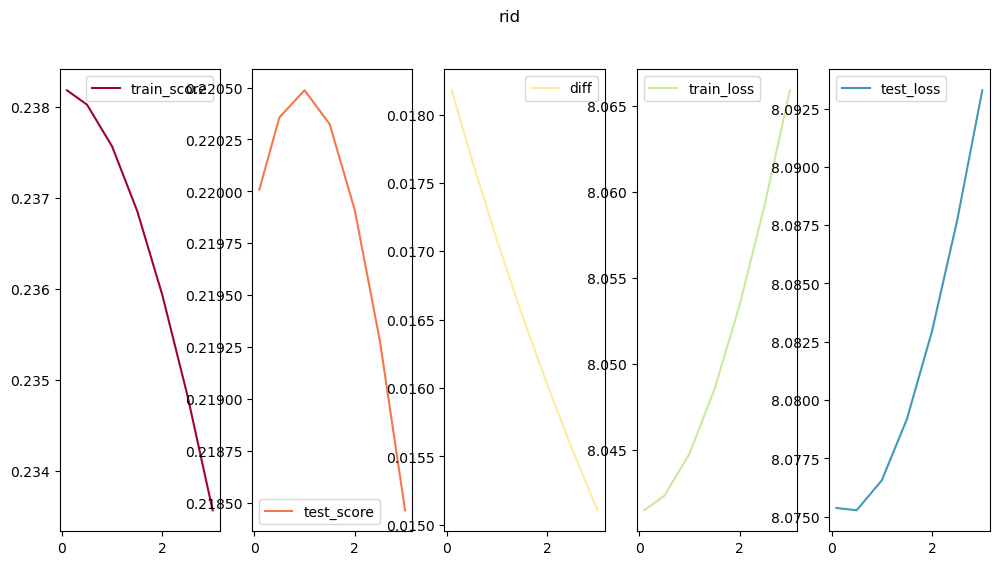

In [14]:
ft_choice(nowDF.columns[1:3],'rid')

Index(['rm', 'lstat'], dtype='object')
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.555501    0.537896  0.017606    6.141805   6.206164
0.5    0.5     0.554609    0.538110  0.016499    6.147965   6.207385
1.0    1.0     0.552102    0.536804  0.015298    6.165246   6.219014
1.5    1.5     0.548380    0.534114  0.014266    6.190813   6.239480
2.0    2.0     0.543725    0.530351  0.013374    6.222642   6.266719
2.5    2.5     0.538359    0.525760  0.012599    6.259135   6.299087
3.0    3.0     0.532456    0.520535  0.011921    6.299030   6.335278


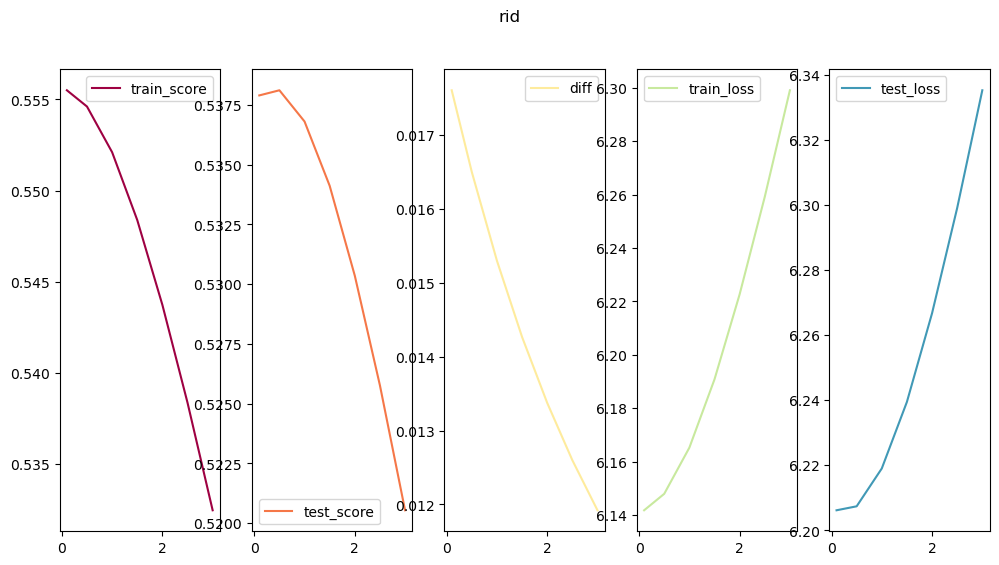

In [15]:
ft_choice(nowDF.columns[5:13:7],'rid')

['crim', 'zn']
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.140603    0.124665  0.015938    8.540697   8.557878
0.5    0.5     0.086679    0.072081  0.014598    8.804008   8.830090
1.0    1.0     0.000000   -0.005192  0.005192    9.214612   9.194466
1.5    1.5     0.000000   -0.005192  0.005192    9.214612   9.194466
2.0    2.0     0.000000   -0.005192  0.005192    9.214612   9.194466
2.5    2.5     0.000000   -0.005192  0.005192    9.214612   9.194466
3.0    3.0     0.000000   -0.005192  0.005192    9.214612   9.194466


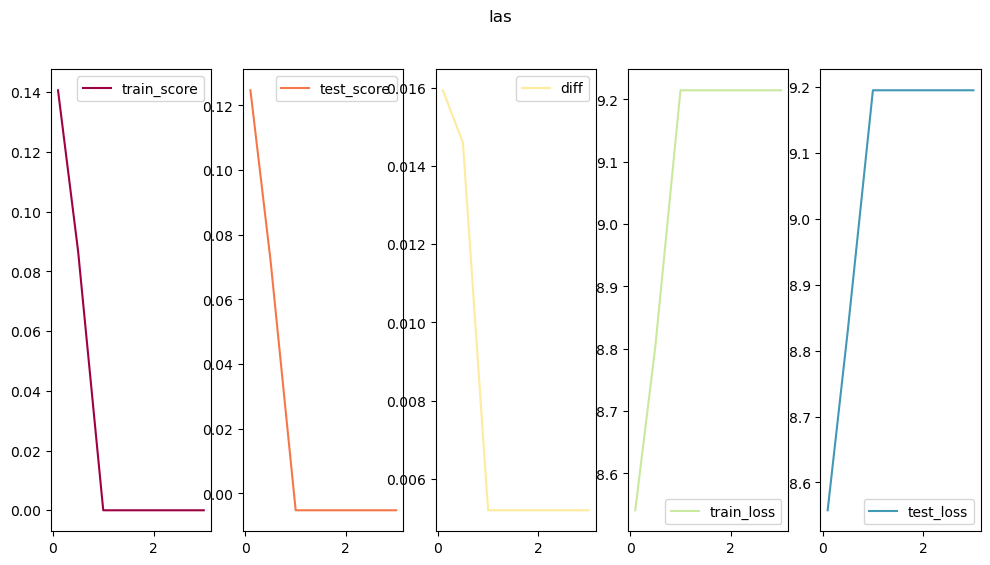

In [16]:
ft_choice(['crim','zn'],'las')

['rm', 'lstat']
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.552487    0.536698  0.015790    6.162567   6.219484
0.5    0.5     0.479192    0.469709  0.009483    6.647413   6.672544
1.0    1.0     0.250144    0.243691  0.006453    7.974064   7.985020
1.5    1.5     0.000000   -0.005192  0.005192    9.214612   9.194466
2.0    2.0     0.000000   -0.005192  0.005192    9.214612   9.194466
2.5    2.5     0.000000   -0.005192  0.005192    9.214612   9.194466
3.0    3.0     0.000000   -0.005192  0.005192    9.214612   9.194466


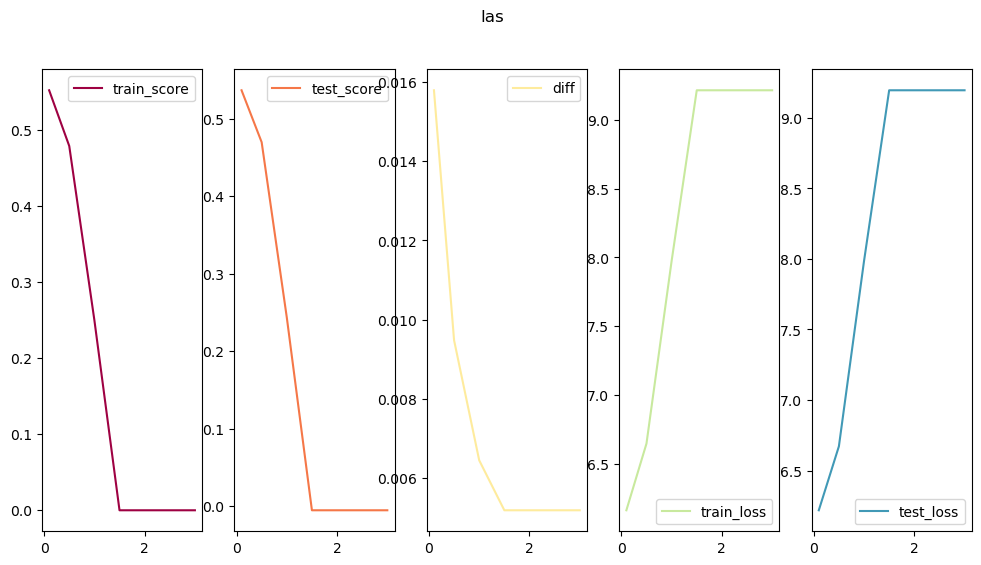

In [17]:
ft_choice(['rm','lstat'],'las')

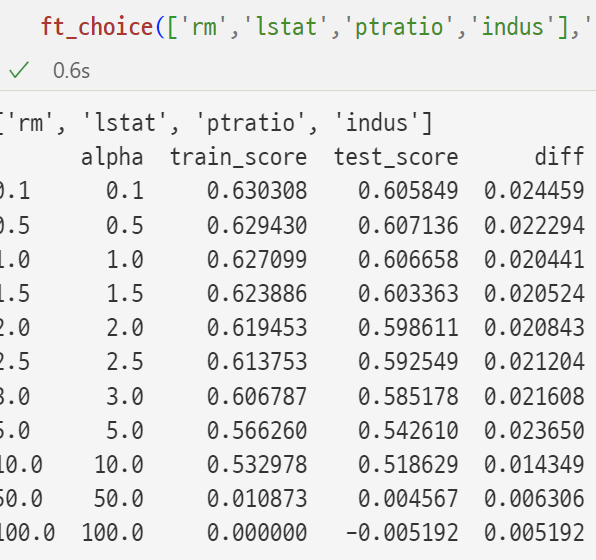

['rm', 'lstat', 'ptratio', 'indus']
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.625738    0.608592  0.017146    5.635809   5.720753
0.5    0.5     0.533389    0.524146  0.009243    6.292285   6.327157
1.0    1.0     0.251874    0.244578  0.007295    7.965176   7.980022
1.5    1.5     0.000000   -0.005192  0.005192    9.214612   9.194466
2.0    2.0     0.000000   -0.005192  0.005192    9.214612   9.194466
2.5    2.5     0.000000   -0.005192  0.005192    9.214612   9.194466
3.0    3.0     0.000000   -0.005192  0.005192    9.214612   9.194466


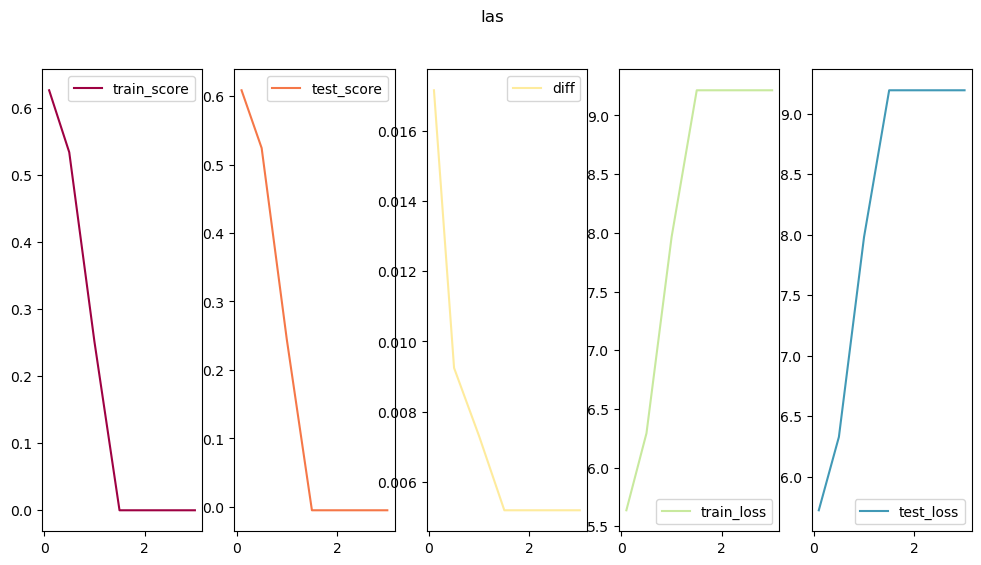

In [18]:
ft_choice(['rm','lstat','ptratio','indus'],'las')

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.704451    0.674938  0.029513    5.008695   5.221793
0.5    0.5     0.533075    0.521449  0.011626    6.294376   6.345646
1.0    1.0     0.253981    0.242342  0.011639    7.953926   7.994173
1.5    1.5     0.000000   -0.005192  0.005192    9.214612   9.194466
2.0    2.0     0.000000   -0.005192  0.005192    9.214612   9.194466
2.5    2.5     0.000000   -0.005192  0.005192    9.214612   9.194466
3.0    3.0     0.000000   -0.005192  0.005192    9.214612   9.194466


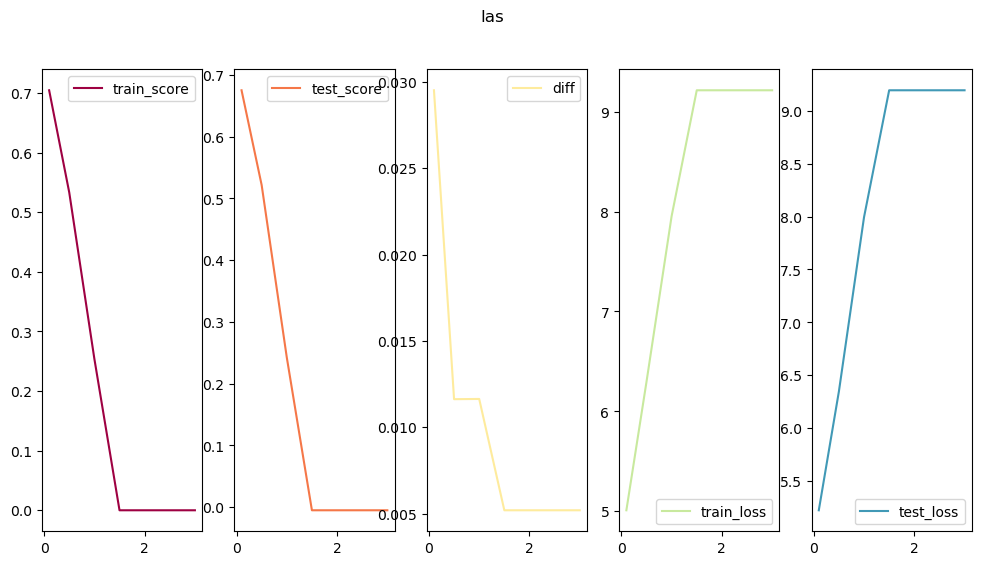

In [19]:
ft_choice(nowDF.columns[:-1],'las')

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.571745    0.550094  0.021651    6.028850   6.148585
0.5    0.5     0.307528    0.296536  0.010993    7.667278   7.700527
1.0    1.0     0.164169    0.157663  0.006506    8.424092   8.424496
1.5    1.5     0.081745    0.075609  0.006136    8.829778   8.822205
2.0    2.0     0.033634    0.027797  0.005837    9.058261   9.044808
2.5    2.5     0.008169    0.002414  0.005755    9.176849   9.160496
3.0    3.0     0.000000   -0.005192  0.005192    9.214612   9.194466


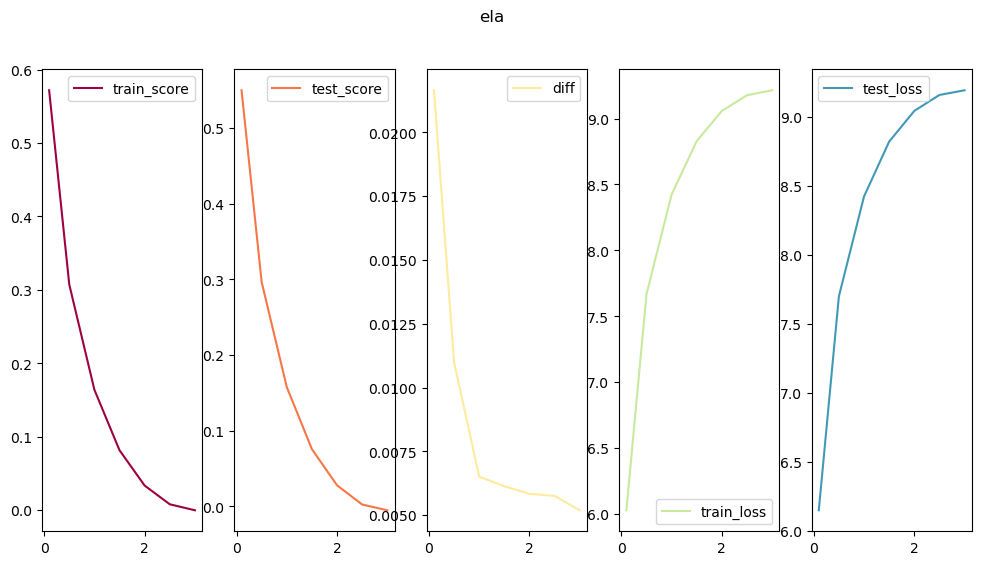

In [20]:
ft_choice(nowDF.columns[:-1],'ela')

['rm', 'lstat', 'ptratio', 'indus', 'tax']
     alpha  train_score  test_score      diff  train_loss  test_loss
0.1    0.1     0.492149    0.484335  0.007814    6.565631   6.586962
0.5    0.5     0.247846    0.243570  0.004276    7.991262   7.984409
1.0    1.0     0.125686    0.120974  0.004712    8.615957   8.603648
1.5    1.5     0.063538    0.058327  0.005211    8.916927   8.902586
2.0    2.0     0.025991    0.020411  0.005580    9.093914   9.078512
2.5    2.5     0.005709    0.000286  0.005423    9.188150   9.170195
3.0    3.0     0.000000   -0.005192  0.005192    9.214612   9.194466


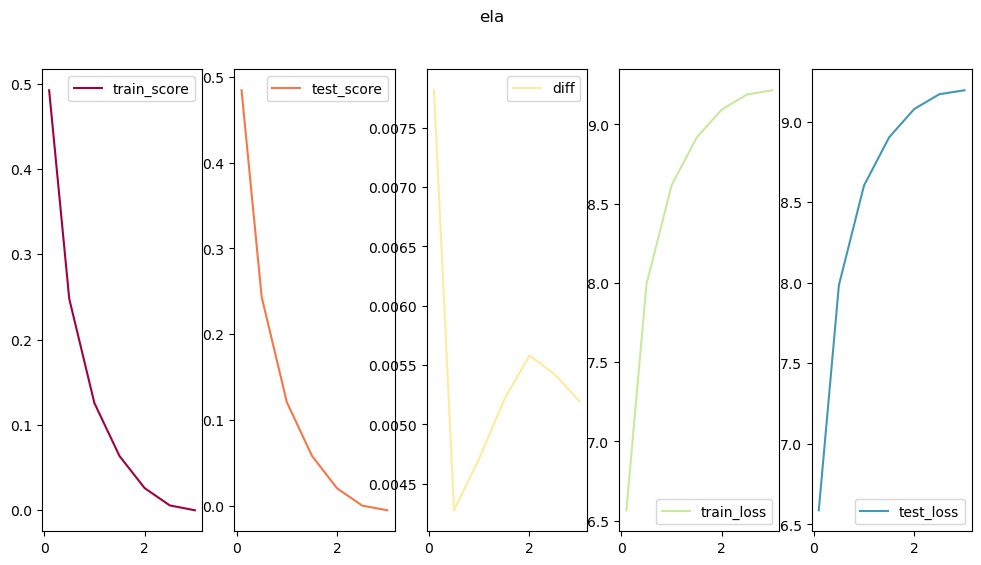

In [21]:
ft_choice(['rm','lstat','ptratio','indus','tax'],'ela')

### 정규화를 하면. 하이퍼 파라미터 알파의 의미가 없어진다.
### 그러면 다항회귀에서 해결하는게? 맞다.
### 
